In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.spatial import Voronoi
from typing import List, Dict, Any, Tuple
from shapely.geometry import MultiPoint, box
from shapely.ops import voronoi_diagram

In [2]:
# Simulation parameters
STEP_COUNT = 120            # Number of simulation frames (total steps in animation)
ANIMATION_INTERVAL = 150    # Delay between frames in milliseconds (controls animation speed)

# Field
FIELD_SIZE = (100, 100)

SEED_SPAWN_AREA = {
    "x": (20, 80),          # Horizontal spawn range for static seed points
    "y": (20, 80),          # Vertical spawn range for static seed points
}
NUM_POINTS = 7              # Number of static seed points (used for Voronoi diagram generation)

# Robot Swarm
ROBOT_SPAWN_AREA = {
    "x": (20, 80),          # Horizontal spawn range for robots
    "y": (20, 80),          # Vertical spawn range for robots
}
NUM_ROBOTS = 30             # Total number of robots in the swarm
SENSING_RADIUS = 20.0       # Radius within which robots can sense neighbors and seed points
SPEED = 1.0                 # Movement step size per simulation iteration

## Spawn Seeds

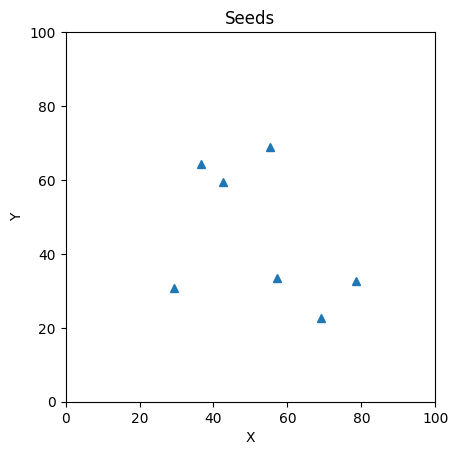

In [3]:
def spawn_points(n: int, range: dict[str, tuple[int, int]]) -> np.ndarray:
    """Spawn `n` random points within the specified `range`."""
    xs = np.random.uniform(range["x"][0], range["x"][1], size=n)
    ys = np.random.uniform(range["y"][0], range["y"][1], size=n)
    return np.c_[xs, ys]

seed_coords = spawn_points(NUM_POINTS, SEED_SPAWN_AREA)

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0]); ax.set_ylim(0, FIELD_SIZE[1]); ax.set_aspect("equal")
ax.set_title("Seeds")
ax.set_xlabel("X"); ax.set_ylabel("Y")
ax.plot(seed_coords[:,0], seed_coords[:,1], '^', linestyle='None')
plt.show()

## Spawn Robots

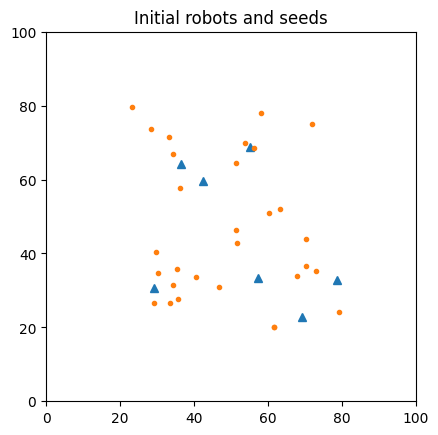

In [4]:
robot_coords = spawn_points(NUM_ROBOTS, ROBOT_SPAWN_AREA)

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0]); ax.set_ylim(0, FIELD_SIZE[1]); ax.set_aspect("equal")
ax.set_title("Initial robots and seeds")
ax.plot(seed_coords[:,0], seed_coords[:,1], '^', linestyle='None')
ax.plot(robot_coords[:,0], robot_coords[:,1], 'o', markersize=3)
plt.show()

## Sensing

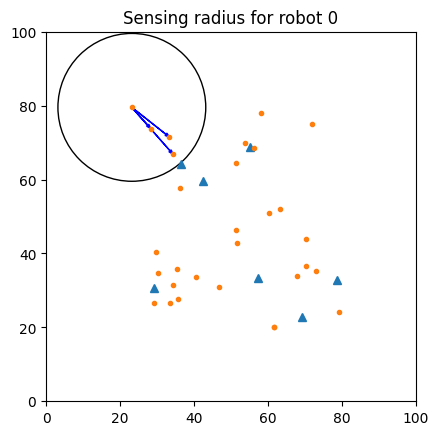

In [5]:
def sensor(
    robot_coords: np.ndarray,
    seed_coords: np.ndarray,
    sensing_radius: float
) -> List[Dict[str, List[Dict[str, Any]]]]:
    num_robots = len(robot_coords)
    results: List[Dict[str, List[Dict[str, Any]]]] = []
    radius_sq = sensing_radius ** 2

    for robot_idx in range(num_robots):
        current_robot_coords = robot_coords[robot_idx]

        # Nearby robots
        relative_robot_vectors = robot_coords - current_robot_coords
        robot_distances_sq = np.einsum("ij,ij->i", relative_robot_vectors, relative_robot_vectors)
        robot_distances_sq[robot_idx] = np.inf  # ignore self
        neighbor_indices = np.where(robot_distances_sq <= radius_sq)[0]

        nearby_robots = [
            {
                "id": int(neighbor_id), # TODO: This wouldn't exist in real sensing
                "vector": relative_robot_vectors[neighbor_id],
                "distance": float(np.sqrt(robot_distances_sq[neighbor_id])),
            }
            for neighbor_id in neighbor_indices
        ]

        # Nearby seed points
        relative_point_vectors = seed_coords - current_robot_coords
        point_distances_sq = np.einsum("ij,ij->i", relative_point_vectors, relative_point_vectors)
        nearby_point_indices = np.where(point_distances_sq <= radius_sq)[0]

        nearby_points = [
            {
                "id": int(point_id), # TODO: This wouldn't exist in real sensing
                "position": (float(seed_coords[point_id, 0]), float(seed_coords[point_id, 1])), # TODO: This wouldn't exist in real sensing
                "vector": relative_point_vectors[point_id],
                "distance": float(np.sqrt(point_distances_sq[point_id])),
            }
            for point_id in nearby_point_indices
        ]

        results.append({
            "robots": nearby_robots,
            "seeds": nearby_points
        })

    return results

# Visualize sensing for robot k
active_robot_index = 0
scans = sensor(robot_coords, seed_coords, SENSING_RADIUS)

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0])
ax.set_ylim(0, FIELD_SIZE[1])
ax.set_aspect("equal")
ax.set_title(f"Sensing radius for robot {active_robot_index}")
ax.plot(seed_coords[:, 0], seed_coords[:, 1], '^', linestyle='None')
ax.plot(robot_coords[:, 0], robot_coords[:, 1], 'o', markersize=3)
circle = plt.Circle(robot_coords[active_robot_index], SENSING_RADIUS, fill=False)
ax.add_patch(circle)

# neighbor vectors
for nb in scans[active_robot_index]["robots"]:
    v = nb['vector']
    ax.arrow(robot_coords[active_robot_index, 0], robot_coords[active_robot_index, 1], v[0], v[1],
             head_width=0.8, length_includes_head=True, color='blue')

# seed point vectors
for pt in scans[active_robot_index]["seeds"]:
    v = pt['vector']
    ax.arrow(robot_coords[active_robot_index, 0], robot_coords[active_robot_index, 1], v[0], v[1],
             head_width=0.8, length_includes_head=True, color='green')

plt.show()

## Messaging ipynb dasf

In [6]:
def send_distance_info_from_scans(inbox: List[list], scans: List[Dict[str, List[Dict[str, Any]]]]) -> None:
    for i, scan in enumerate(scans):
        for ninfo in scan["robots"]:
            j = ninfo["id"]
            inbox[j].append({
                "type": "distance_info",
                "from": i,
                "to": j,
                "seeds": scan["seeds"],
                "robots": scan["robots"],
            })
            
from pprint import pprint

# Show inbox content for one robot
inboxes: List[list] = [[] for _ in range(NUM_ROBOTS)] # Initialize message inbox for each robot
send_distance_info_from_scans(inboxes, scans)
print("Sample inbox for robot", active_robot_index)
pprint(inboxes[active_robot_index])

Sample inbox for robot 0
[{'from': 5,
  'robots': [{'distance': 7.673059484318897,
              'id': 0,
              'vector': array([-5.10048629,  5.73244114])},
             {'distance': 9.189122197127102,
              'id': 16,
              'vector': array([ 6.02874245, -6.93500045])},
             {'distance': 18.069595484534954,
              'id': 26,
              'vector': array([  8.038002  , -16.18334962])},
             {'distance': 5.5701780252953945,
              'id': 27,
              'vector': array([ 5.07081819, -2.3051434 ])}],
  'seeds': [{'distance': 12.635737116738735,
             'id': 6,
             'position': (36.55678238907981, 64.22742437812886),
             'vector': array([ 8.25669678, -9.56497834])}],
  'to': 0,
  'type': 'distance_info'},
 {'from': 16,
  'robots': [{'distance': 16.86190406869457,
              'id': 0,
              'vector': array([-11.12922874,  12.66744159])},
             {'distance': 9.189122197127102,
              'id': 5,

## Behavior

Local neighbors: 3 Fused neighbors: 6
Local seeds: 0 Fused seeds: 10
Repulsion vector: [-0.05645155  0.06344595] Drive vector: [0.73648618 0.67645259]


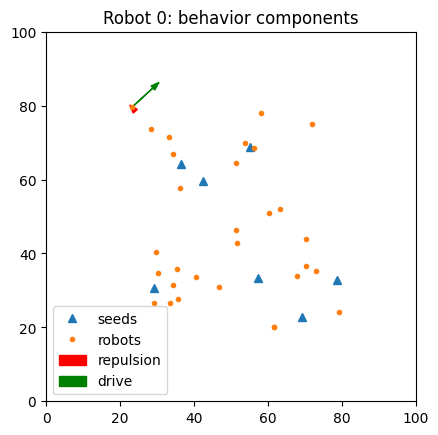

In [7]:
def pop_inbox(inbox: List[list]) -> List[list]:
    """Clear the inbox and return all messages."""
    msgs = [m[:] for m in inbox]
    for q in inbox:
        q.clear()
    return msgs

def behavior(
    robot_index: int,
    robot_positions: np.ndarray,
    sensing_radius: float,
    inboxes: List[list]
):
    # Sensing for this robot
    scan = sensor(robot_positions, seed_coords, sensing_radius)[robot_index]
    robots = scan["robots"]
    seeds = scan["seeds"]

    # Collect incoming messages
    inbox = pop_inbox(inboxes)[robot_index]

    # Prepare merged data structures
    combined_neighbors = robots[:]
    combined_seeds = seeds[:]

    # Fuse data from received messages
    for message in inbox:
        if message.get("type") != "distance_info":
            continue

        sender_id = message["from"]
        translation_vector = next(
            (neighbor["vector"] for neighbor in combined_neighbors if neighbor["id"] == sender_id),
            None
        )
        if translation_vector is None:
            continue

        # Merge seeds information
        for seed in message["seeds"]:
            adjusted_vector = seed["vector"] + translation_vector
            combined_seeds.append({
                "id": seed["id"],
                "position": seed["position"],
                "vector": adjusted_vector,
                "distance": float(np.linalg.norm(adjusted_vector)),
            })

        # Merge neighbor information
        for neighbor in message["robots"]:
            if neighbor["id"] == robot_index:
                continue
            adjusted_vector = neighbor["vector"] + translation_vector
            distance = float(np.linalg.norm(adjusted_vector))
            existing_index = next(
                (k for k, n in enumerate(combined_neighbors) if n["id"] == neighbor["id"]),
                None
            )
            if existing_index is None:
                combined_neighbors.append({"id": neighbor["id"], "vector": adjusted_vector, "distance": distance})
            elif distance < combined_neighbors[existing_index]["distance"]:
                combined_neighbors[existing_index] = {"id": neighbor["id"], "vector": adjusted_vector, "distance": distance}

    # Compute repulsion from nearby neighbors
    repulsion_vector = np.zeros(2)
    for neighbor in combined_neighbors:
        distance = neighbor["distance"]
        if distance <= 1e-6:
            continue
        if distance < sensing_radius / 2:
            repulsion_vector -= (neighbor["vector"] / distance) * (1.0 / distance**2)
    repulsion_vector *= 5.0

    # Compute attraction/drive toward balanced seed spacing
    if len(combined_seeds) >= 2:
        sorted_seeds = sorted(combined_seeds, key=lambda s: s["distance"])
        closest_seed = sorted_seeds[0]
        farthest_seed = sorted_seeds[-1]
        drive_vector = (
            (farthest_seed["vector"] / max(farthest_seed["distance"], 1e-9)) -
            (closest_seed["vector"] / max(closest_seed["distance"], 1e-9))
        )
        if np.linalg.norm(drive_vector) > 1e-6:
            drive_vector /= np.linalg.norm(drive_vector)
    else:
        drive_vector = np.zeros(2)

    return robots, seeds, combined_neighbors, combined_seeds, repulsion_vector, drive_vector


# Demonstration: decompose for one robot
scans = sensor(robot_coords, seed_coords, SENSING_RADIUS)
send_distance_info_from_scans(inboxes, scans)

(
    local_neighbors,
    local_seeds,
    fused_neighbors,
    fused_seeds,
    repulsion_vector,
    drive_vector
) = behavior(active_robot_index, robot_coords, SENSING_RADIUS, inboxes)

print("Local neighbors:", len(local_neighbors), "Fused neighbors:", len(fused_neighbors))
print("Local seeds:", len(local_seeds), "Fused seeds:", len(fused_seeds))
print("Repulsion vector:", repulsion_vector, "Drive vector:", drive_vector)

# Visualization
fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0])
ax.set_ylim(0, FIELD_SIZE[1])
ax.set_aspect("equal")
ax.set_title(f"Robot {active_robot_index}: behavior components")
ax.plot(seed_coords[:, 0], seed_coords[:, 1], '^', linestyle='None', label="seeds")
ax.plot(robot_coords[:, 0], robot_coords[:, 1], 'o', markersize=3, label="robots")

# visual scale factor for clarity
ARROW_SCALE = 10.0

# extended repulsion arrow
ax.arrow(
    robot_coords[active_robot_index, 0],
    robot_coords[active_robot_index, 1],
    repulsion_vector[0] * ARROW_SCALE,
    repulsion_vector[1] * ARROW_SCALE,
    head_width=1.5,
    length_includes_head=True,
    color="red",
    label="repulsion"
)

# extended drive arrow
ax.arrow(
    robot_coords[active_robot_index, 0],
    robot_coords[active_robot_index, 1],
    drive_vector[0] * ARROW_SCALE,
    drive_vector[1] * ARROW_SCALE,
    head_width=1.5,
    length_includes_head=True,
    color="green",
    label="drive"
)

ax.legend()
plt.show()

## One-step update

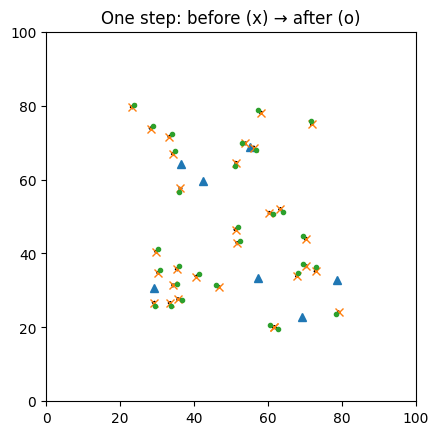

In [8]:
def one_step(robot_positions: np.ndarray):
    # Local scans and message broadcast
    scans = sensor(robot_positions, seed_coords, SENSING_RADIUS)
    send_distance_info_from_scans(inboxes, scans)
    messages_per_robot = pop_inbox(inboxes)

    # Update per robot
    for i in range(len(robot_positions)):
        neighbors = scans[i]["robots"][:]  # local neighbors
        seeds     = scans[i]["seeds"][:]   # local seeds

        # Fuse received information into the local frame
        for msg in messages_per_robot[i]:
            if msg.get('type') != 'distance_info':
                continue
            sender_id = msg['from']
            translation_vector = next(
                (n['vector'] for n in neighbors if n['id'] == sender_id), None
            )
            if translation_vector is None:
                continue

            # Seeds
            for seed in msg['seeds']:
                adjusted_vec = seed['vector'] + translation_vector
                seeds.append({
                    'id': seed['id'],
                    'position': seed['position'],
                    'vector': adjusted_vec,
                    'distance': float(np.linalg.norm(adjusted_vec)),
                })

            # Neighbors
            for nb in msg['robots']:
                if nb['id'] == i:
                    continue
                adjusted_vec = nb['vector'] + translation_vector
                dist = float(np.linalg.norm(adjusted_vec))
                existing = next((k for k, x in enumerate(neighbors) if x['id'] == nb['id']), None)
                if existing is None:
                    neighbors.append({'id': nb['id'], 'vector': adjusted_vec, 'distance': dist})
                elif dist < neighbors[existing]['distance']:
                    neighbors[existing] = {'id': nb['id'], 'vector': adjusted_vec, 'distance': dist}

        # Forces
        repulsion = np.zeros(2)
        for nb in neighbors:
            d = nb['distance']
            if d <= 1e-6:
                continue
            if d < SENSING_RADIUS/2:
                repulsion -= (nb['vector'] / d) * (1.0 / d**2)
        repulsion *= 5.0

        if len(seeds) >= 2:
            seeds_sorted = sorted(seeds, key=lambda s: s['distance'])
            near, far = seeds_sorted[0], seeds_sorted[-1]
            drive = (far['vector'] / max(far['distance'], 1e-9)) - (near['vector'] / max(near['distance'], 1e-9))
            if np.linalg.norm(drive) > 1e-6:
                drive /= np.linalg.norm(drive)
        else:
            drive = np.zeros(2)

        move = drive + repulsion
        if np.linalg.norm(move) > 1e-2:
            step = move / np.linalg.norm(move) * SPEED
            robot_positions[i] = robot_positions[i] + step
            robot_positions[i, 0] = np.clip(robot_positions[i, 0], 0, FIELD_SIZE[0])
            robot_positions[i, 1] = np.clip(robot_positions[i, 1], 0, FIELD_SIZE[1])

pos_before = robot_coords.copy()
one_step(robot_coords)
pos_after = robot_coords.copy()

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0]); ax.set_ylim(0, FIELD_SIZE[1]); ax.set_aspect("equal")
ax.set_title("One step: before (x) → after (o)")
ax.plot(seed_coords[:,0], seed_coords[:,1], '^', linestyle='None')
ax.plot(pos_before[:,0], pos_before[:,1], 'x')
ax.plot(pos_after[:,0], pos_after[:,1], 'o', markersize=3)
for i in range(len(pos_before)):
    dx, dy = pos_after[i] - pos_before[i]
    ax.arrow(pos_before[i,0], pos_before[i,1], dx, dy, head_width=0.8, length_includes_head=True)
plt.show()

## Voronoi Drawing

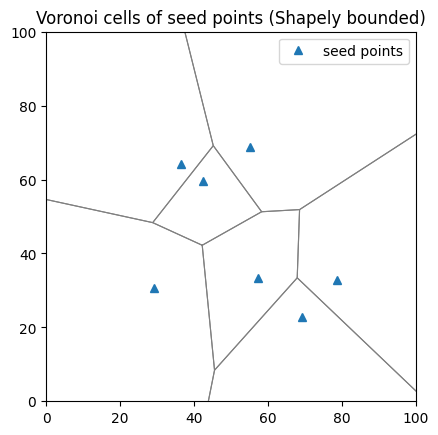

In [9]:
def draw_voronoi(points: np.ndarray, width: int, height: int, ax, artists_store: list):
    # clear old artists
    for artist in artists_store:
        artist.remove()
    artists_store.clear()

    if len(points) < 2:
        return

    # build bounded diagram
    bbox = box(0, 0, width, height)
    mp = MultiPoint([tuple(p) for p in points])
    cells = voronoi_diagram(mp, envelope=bbox, edges=False)  # polygons, already clipped

    # draw polygons
    for poly in cells.geoms:
        x, y = poly.exterior.xy
        line, = ax.plot(x, y, 'gray', lw=0.8, zorder=0)
        artists_store.append(line)
        # optional: draw holes if present
        for ring in poly.interiors:
            xi, yi = ring.xy
            hole, = ax.plot(xi, yi, 'gray', lw=0.6, zorder=0)
            artists_store.append(hole)

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0])
ax.set_ylim(0, FIELD_SIZE[1])
ax.set_aspect("equal")
ax.set_title("Voronoi cells of seed points (Shapely bounded)")

# Plot seeds
ax.plot(seed_coords[:, 0], seed_coords[:, 1], '^', label='seed points')

# Use the Shapely-based Voronoi drawer
voronoi_artists = []
draw_voronoi(seed_coords, FIELD_SIZE[0], FIELD_SIZE[1], ax, voronoi_artists)

ax.legend()
plt.show()

In [10]:
PATHS: List[list] = [[robot_coords[i].copy()] for i in range(NUM_ROBOTS)]

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0]); ax.set_ylim(0, FIELD_SIZE[1]); ax.set_aspect("equal")
ax.set_title("Full run")
ax.set_xlabel("X"); ax.set_ylabel("Y")
ax.plot(seed_coords[:,0], seed_coords[:,1], '^', linestyle='None')

scatters = [ax.plot([], [], 'o', markersize=4)[0] for _ in range(NUM_ROBOTS)]
trails = [ax.plot([], [], '-', linewidth=1, alpha=0.25)[0] for _ in range(NUM_ROBOTS)]
voronoi_lines = []
frame_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, fontsize=10,
                     verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

def update(frame):
    # Local scans and broadcast
    scans = sensor(robot_coords, seed_coords, SENSING_RADIUS)
    send_distance_info_from_scans(inboxes, scans)
    messages_per_robot = pop_inbox(inboxes)

    # Update robots
    for i in range(len(robot_coords)):
        neighbors = scans[i]["robots"][:]
        seeds     = scans[i]["seeds"][:]

        for msg in messages_per_robot[i]:
            if msg.get('type') != 'distance_info':
                continue
            sender_id = msg['from']
            translation_vector = next(
                (n['vector'] for n in neighbors if n['id'] == sender_id), None
            )
            if translation_vector is None:
                continue

            for seed in msg['seeds']:
                adjusted_vec = seed['vector'] + translation_vector
                seeds.append({
                    'id': seed['id'],
                    'position': seed['position'],
                    'vector': adjusted_vec,
                    'distance': float(np.linalg.norm(adjusted_vec)),
                })

            for nb in msg['robots']:
                if nb['id'] == i:
                    continue
                adjusted_vec = nb['vector'] + translation_vector
                dist = float(np.linalg.norm(adjusted_vec))
                existing = next((k for k, x in enumerate(neighbors) if x['id'] == nb['id']), None)
                if existing is None:
                    neighbors.append({'id': nb['id'], 'vector': adjusted_vec, 'distance': dist})
                elif dist < neighbors[existing]['distance']:
                    neighbors[existing] = {'id': nb['id'], 'vector': adjusted_vec, 'distance': dist}

        # Forces
        repulsion = np.zeros(2)
        for nb in neighbors:
            d = nb['distance']
            if d <= 1e-6:
                continue
            if d < SENSING_RADIUS/2:
                repulsion -= (nb['vector'] / d) * (1.0 / d**2)
        repulsion *= 5.0

        if len(seeds) >= 2:
            seeds_sorted = sorted(seeds, key=lambda s: s['distance'])
            near, far = seeds_sorted[0], seeds_sorted[-1]
            drive = (far['vector'] / max(far['distance'], 1e-9)) - (near['vector'] / max(near['distance'], 1e-9))
            if np.linalg.norm(drive) > 1e-6:
                drive /= np.linalg.norm(drive)
        else:
            drive = np.zeros(2)

        move = drive + repulsion
        if np.linalg.norm(move) > 1e-2:
            step = move / np.linalg.norm(move) * SPEED
            robot_coords[i] = robot_coords[i] + step
            robot_coords[i, 0] = np.clip(robot_coords[i, 0], 0, FIELD_SIZE[0])
            robot_coords[i, 1] = np.clip(robot_coords[i, 1], 0, FIELD_SIZE[1])

    # Draw
    for i in range(NUM_ROBOTS):
        PATHS[i].append(robot_coords[i].copy())
        xs, ys = zip(*PATHS[i])
        scatters[i].set_data([xs[-1]], [ys[-1]])
        trails[i].set_data(xs, ys)

    # Voronoi overlay
    draw_voronoi(seed_coords, FIELD_SIZE[0], FIELD_SIZE[1], ax, voronoi_lines)
    frame_text.set_text(f"Frame: {frame+1}/{STEP_COUNT}")
    if frame == STEP_COUNT - 1:
        for t in trails:
            t.set_data([], [])
    return scatters + trails + voronoi_lines + [frame_text]

ani = FuncAnimation(fig, update, frames=STEP_COUNT, interval=ANIMATION_INTERVAL, blit=True, repeat=False)
# ani.save("voronoi.gif", fps=int(1000/ANIMATION_INTERVAL), writer='pillow')
# fig.savefig("voronoi.png", dpi=300, bbox_inches='tight')
plt.close(fig)
HTML(ani.to_jshtml()) 